In [94]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from urllib.parse import urlparse
import mlflow
import mlflow
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import scipy
from scipy import stats
import pickle
import helper

In [159]:
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
pd.set_option('display.float_format',lambda x:'%5f'%x)
data = pd.read_csv('../data/AdSmartABdata.csv')

 Data Understanding

In [160]:
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [118]:
# size of the data
data.size

72693

In [119]:
# data type of the data frame
data.dtypes

auction_id     object
experiment     object
date           object
hour            int64
device_make    object
platform_os     int64
browser        object
yes             int64
no              int64
dtype: object

In [120]:
data['date'] = pd.to_datetime(data['date'])

Task 1.2 Classic and sequential A/B testing analysis

In [121]:
# Data exploration
# printing number of unique values and unique values
print('The number of unique devices: ', data['device_make'].nunique())
print('Unique Browsers: ', data['browser'].unique())
print('platform_os: ', data['platform_os'].unique())


The number of unique devices:  270
Unique Browsers:  ['Chrome Mobile' 'Chrome Mobile WebView' 'Facebook' 'Mobile Safari'
 'Chrome Mobile iOS' 'Samsung Internet' 'Mobile Safari UI/WKWebView'
 'Chrome' 'Opera Mini' 'Edge Mobile' 'Android' 'Pinterest' 'Opera Mobile'
 'Firefox Mobile' 'Puffin']
platform_os:  [6 5 7]


In [122]:
# checking if missing values are there
data.isnull().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [123]:
# plotting functions
def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    plt.figure(figsize=(9, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    
def plot_dist(df:pd.DataFrame, column:str):
    plt.figure(figsize=(9,7))
    sns.distplot(df).set_title(f'Distribution of {column}')
    


def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=column)
    plt.title(f'Plot count of {column}', size=20, fontweight='bold')
    plt.xticks(rotation=70)
    
def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    

def plot_heatmap(df:pd.DataFrame, title:str, cbar=False)->None:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', linewidths=.7, cbar=cbar )
    plt.title(title, size=18, fontweight='bold')
    

def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    
def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)

def plot_counttwo(df,col1,col2):
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    sns.countplot(data=df, x=col1,palette='summer')
    plt.title(f'Distribution of {col1}', size=16, fontweight='bold')
    plt.xticks(rotation=70)
    
    plt.subplot(1,2,2)
    sns.countplot(data=df, x=col2,palette='summer_r')
    plt.title(f'Distribution of {col2}', size=16, fontweight='bold')
    plt.xticks(rotation=70)
    plt.show()

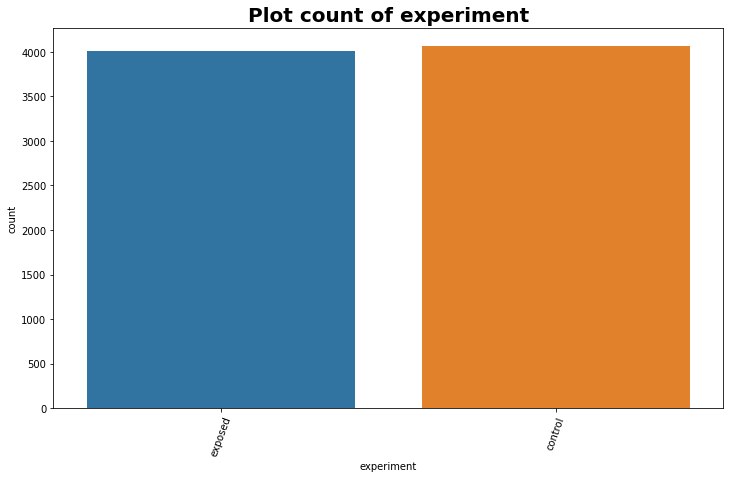

In [124]:
# plotting the experiment column
plot_count(data,'experiment')

**As we can see from the figure the online users are equally distributed to the exposed and control groups.**  

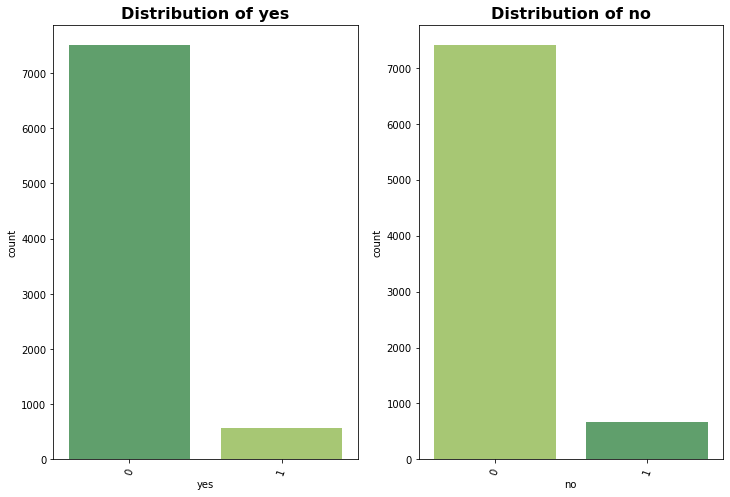

In [125]:
plot_counttwo(data,'yes','no')

**As we can see from the figure most of the users did not answer the questions.**

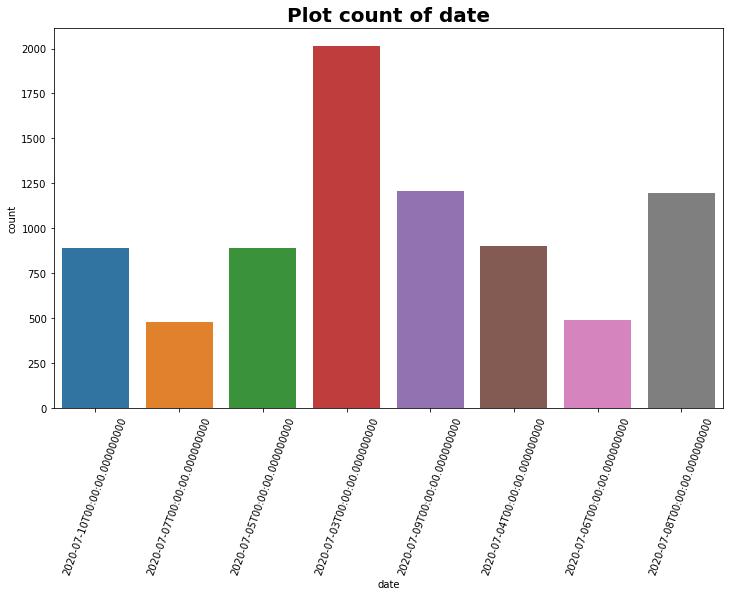

In [126]:
plot_count(data, 'date')

**As we can see from the figure most of the users has engaged with the question at the first day.**

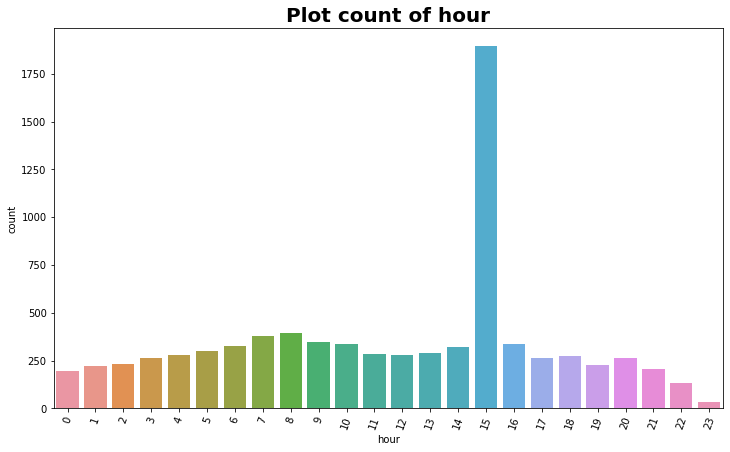

In [127]:
plot_count(data, 'hour')

**Most of the users were engaged to the question around 12pm UTc**

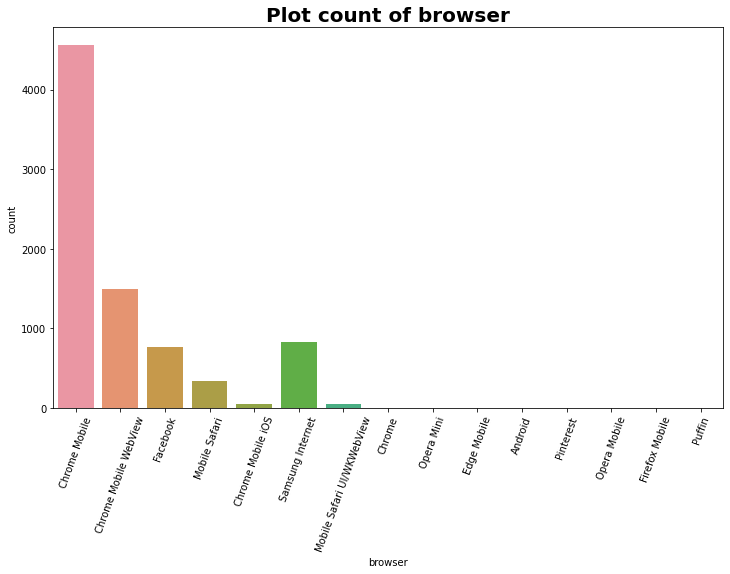

In [128]:
plot_count(data, 'browser')

Most of the users uses chrome mobile

**Hypothesis testing**

**To perform hypothesis testing there are many rows that does not have 1 in either yes or no columns.**
* let us see if this types of users are evenly distributed to the groups

In [129]:
# locating the rows which have control and which have exposed
control = data.loc[data['experiment'] == 'control']
exposed = data.loc[data['experiment'] == 'exposed']

In [130]:
# locating the rows for both of groups for whom the users  did not answer the question
control_unanswered = data.loc[(data['yes'] == 0) & (data['no'] == 0) & (data['experiment'] == 'control')]
exposed_unanswered = data.loc[(data['yes'] == 0) & (data['no'] == 0) & (data['experiment'] == 'exposed')]

In [131]:
# finding the percent of the users who did not answer for control group
control_unanswered.shape[0]/control.shape[0] * 100

85.60550233357898

In [132]:
# finding the percent of the users who did not answer for exposed group
exposed_unanswered.shape[0]/exposed.shape[0] * 100

83.59960059910134

**The number of the users that did not answer the question for both of the group are almost similar so if we drop those rows it will not affect our analysis.**

In [133]:
newdata = data.drop(data[(data['yes'] ==0) &(data['no']==0)].index)
newdata.shape

(1243, 9)

* <h2>Based on the above plots the exposed group seems to have more counts of yes than the exposed group.But We can not conclude based on the difference only that the SmartAd increased brand awareness<h2>

<h1> Classical testing analysis</h1>

<h2>Performing hypothesis testing: For hypothesis testing we need to have two sample hypothesis which are the Null hypothesis and the Alternative hypothesis, the hypothesis are as follows</h2>

**Null hypothesis:** there is no significant difference in brand awareness between the exposed and control groups it is just natural variance

**Alternate hypothesis:** there is a significant difference in brand awareness between the exposed and control groups 

* To reject our null hypothesis, we have to prove that there is a statistically significant difference 

* Given that the outcome of the questionnaire is binary, we use the chi-square test method to check whether the differences of the control and experiment groups were significant
- from the bussiness perspective lets say a 2% brand awarenes increase would be practically significant.dmin=0.02
- and have a confidence level of 95%

*If d>1.96SEpool or d<-1.96SEpool Reject the null

In [134]:
newdata.shape

(1243, 9)

In [135]:
#Creating a table with a summary of the observed outcomes
df=newdata.groupby('experiment').agg({'yes':'sum','no':'sum'})
df.loc[:,'Total']=df.sum(axis=1)
df.head()

,yes,no,Total
experiment,,,
control,264,322,586
exposed,308,349,657


In [136]:
controlyes=df['yes'][0]
controlno=df['no'][0]
exposedyes=df['yes'][1]
exposedno=df['no'][1]
TOtalcontrol = df['Total'][0]
TOtalexposed = df['Total'][1]

In [137]:
Ppool=(controlyes+exposedyes)/newdata.shape[0]
print(Ppool)

0.46017699115044247


In [138]:
import math
#Pool standard error
SEpool=math.sqrt(Ppool*(1-Ppool)*((1/TOtalcontrol)+(1/TOtalexposed)))
print(SEpool)

0.028319932727228023


In [139]:
## difference between Pexposed and Pcontrol
d=(exposedyes/TOtalexposed)-(controlyes/TOtalcontrol)
print(d)

0.018285619295484168


In [140]:
#margin of error
m=1.96*SEpool
print(m)

0.055507068145366927


In [141]:
lowerboundary=d-m
upperboundary=d+m
print(lowerboundary,upperboundary)

-0.03722144884988276 0.0737926874408511


**From this output that we can say we dont have enough power to draw a conclusion we need more data to reach a conclusion.**

<h1>Task 2: A/B testing with Machine Learning<h1>

In [9]:
File_Path = "../data/AdSmartABdata.csv"

In [51]:
data = pd.read_csv(File_Path)
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [62]:
# droping the users that did not answer
def drop_no_responds(df):
    cleaned_df = df.query("not (yes == 0 & no == 0)")
    return cleaned_df



In [18]:
def read_model(file_name):
    with open(f"../models/{file_name}.pkl", "rb") as f:
        return pickle.load(f)

def write_model(file_name, model):
    with open(f"../models/{file_name}.pkl", "wb") as f:
        pickle.dump(model, f)

<h3>Data Transformation<h3>

In [72]:
cleaneddata = drop_no_responds(data)
cleaneddata['aware'] = cleaneddata['yes'].map(lambda x: x==1)
cleaneddata = cleaneddata.drop(columns = ['yes', 'no', 'auction_id'], axis=1)
cleaneddata.head()

/home/neba/.conda/envs/abtest/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,experiment,date,hour,device_make,platform_os,browser,aware
2,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,False
16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,True
20,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,False
23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,True
27,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,False


In [19]:
def save_cleaned_data():
    CLEANED_CSV_PATH = "../Data/clean_data.csv"
    pd.save_csv(cleaneddata, CLEANED_CSV_PATH)

Data preparation

In [73]:
# label encoding
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    aware_encoder = preprocessing.LabelEncoder()
    
    df['date'] = date_encoder.fit_transform(df['date'])
    df['device_make'] = device_encoder.fit_transform(df['device_make'])
    df['browser'] = browser_encoder.fit_transform(df['browser'])
    df['experiment'] = experiment_encoder.fit_transform(df['experiment'])
    df['aware'] = aware_encoder.fit_transform(df['aware'])

<h2> Splitting data by platform and browser<h2>

In [25]:

def feature_data(cleaned_df):
    
    browser_df = cleaned_df[['experiment', 'hour', 'date', 'device_make', 'browser', 'aware']]
    platfrom_df = cleaned_df[['experiment', 'hour', 'date', 'device_make', 'platform_os', 'aware']]

    return browser_df, platfrom_df

In [22]:
def save_encoded_df():
    
    browser_df, platfrom_df = feature_data(encoded_df)
    pd.save_csv(browser_df, "../Data/clean_data.csv")
    pd.save_csv(platfrom_df, "../Data/clean_data.csv")

<h2> Model building <h2>

In [97]:
# loss Function
def loss_function(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse

In [98]:
# Decision Tree Model
class DecisionTreesModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, max_depth=5):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.clf = DecisionTreeClassifier(max_depth=4)
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        for i in range(folds):
            train_index, valid_index = next(iterator)
            
            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]
                        
            self.clf = self.clf.fit(X_train, y_train)
            
            vali_pred = self.clf.predict(X_valid)
            
            accuracy = self.calculate_score(y_valid
                                              , vali_pred)
            
            loss = loss_function(y_valid, vali_pred)
            
            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()
            
            acc_arr.append(accuracy)
            loss_arr.append(loss)

            
        return self.clf, acc_arr, loss_arr
    def test(self):
        
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(y_pred, self.y_test)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss,  report, matrix
    def get_feature_importance(self):
        importance = self.clf.feature_importances_
        fi_df = pd.DataFrame()
        
        fi_df['feature'] = self.X_train.columns.to_list()
        fi_df['feature_importances'] = importance
        
        return fi_df
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of DecisionTreesModel is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of DecisionTreesModel is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)
    

In [74]:
# encoding the data
encode_labels(cleaneddata)

In [80]:
platform_df = cleaneddata.drop(['browser'], axis=1)
browser_df = cleaneddata.drop(['platform_os'], axis=1)


In [81]:
print("1. Encoded Dataframe containing the the platfrom column")
platform_df.head()

1. Encoded Dataframe containing the the platfrom column


,experiment,date,hour,device_make,platform_os,aware
2,1,2,2,4,6,0
16,1,1,16,13,6,1
20,1,3,8,13,6,0
23,0,5,4,43,6,1
27,0,0,15,13,6,0


In [82]:
print("1. Encoded Dataframe containing the the browser column")
browser_df.head()

1. Encoded Dataframe containing the the browser column


,experiment,date,hour,device_make,browser,aware
2,1,2,2,4,2,0
16,1,1,16,13,1,1
20,1,3,8,13,1,0
23,0,5,4,43,4,1
27,0,0,15,13,1,0


<h2>1 Model training using Decision Tree using browser dataframe<h2>

Train Test Split

In [83]:

# feature_cols = ['experiment', 'hour', 'date', 'device_make', 'platform_os',  'browser']
feature_cols = ['experiment', 'hour', 'date', 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

Model Training Using DecisionTreesModel

In [100]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

clf, acc_arr, loss_arr = decisionTreesModel.train(5)


step 0: Validation Accuracy of DecisionTreesModel is: 0.571
step 0: Validation Loss of DecisionTreesModel is: 0.655

step 1: Validation Accuracy of DecisionTreesModel is: 0.536
step 1: Validation Loss of DecisionTreesModel is: 0.681

step 2: Validation Accuracy of DecisionTreesModel is: 0.558
step 2: Validation Loss of DecisionTreesModel is: 0.665

step 3: Validation Accuracy of DecisionTreesModel is: 0.507
step 3: Validation Loss of DecisionTreesModel is: 0.702

step 4: Validation Accuracy of DecisionTreesModel is: 0.565
step 4: Validation Loss of DecisionTreesModel is: 0.660




Evaluating our model

step 1: Test Accuracy of DecisionTreesModel is: 0.544
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.53      0.69       116
           1       0.10      0.67      0.17         9

    accuracy                           0.54       125
   macro avg       0.53      0.60      0.43       125
weighted avg       0.89      0.54      0.65       125

Loss on test data is: 0.675



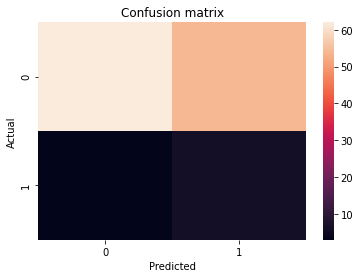

In [101]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()